2025-09-25 10:30:12.887273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758796213.087100      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758796213.143944      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Creating the training dataset...
Found 70295 files belonging to 38 classes.


I0000 00:00:1758796263.163547      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758796263.164266      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Creating the validation dataset...
Found 17572 files belonging to 38 classes.

Found the following 38 classes: 
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


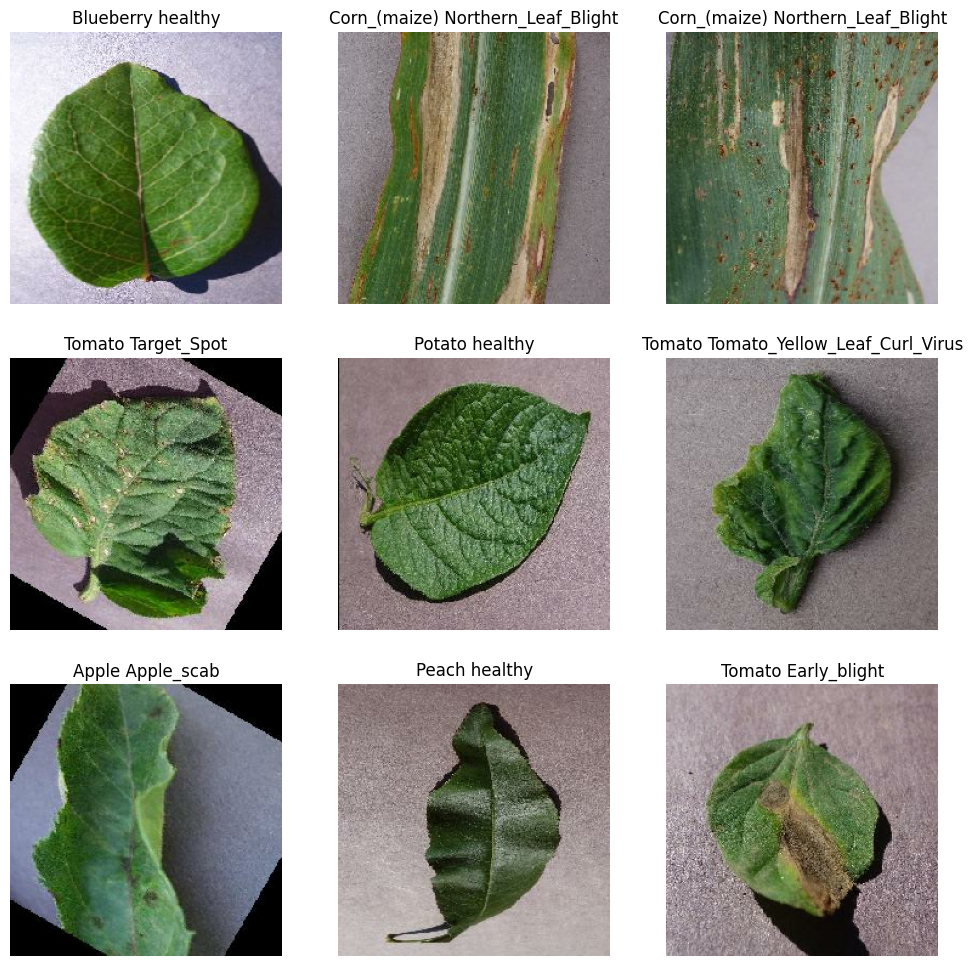

Finish......??????????/////////


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

data_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'

BATCH_SIZE = 32 
IMG_WIDTH = 224  
IMG_HEIGHT = 224 


print("Creating the training dataset...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    labels='inferred',       
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True            
)

print("Creating the validation dataset...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'valid'),
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False            # No need to shuffle validation data
)

# Get the class names that TensorFlow inferred from the folder names
class_names = train_dataset.class_names
print(f"\nFound the following {len(class_names)} classes: \n{class_names[:5]}") # Print first 5

# --- 3. Configure Dataset for Performance ---
# These steps help make data loading much faster
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# .cache() keeps images in memory after they're loaded for the first time
# .prefetch() prepares subsequent batches of data while the GPU is busy

# --- 4. Visualize a Batch of Data ---
# Let's see what a batch looks like to confirm it's working
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1): # Take just one batch
    for i in range(9): # Display the first 9 images of the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # The labels are one-hot encoded, so we find the index of the '1'
        label_index = tf.argmax(labels[i])
        plt.title(class_names[label_index].replace("___", " "))
        plt.axis("off")
plt.show()

print("Finish......??????????/////////")

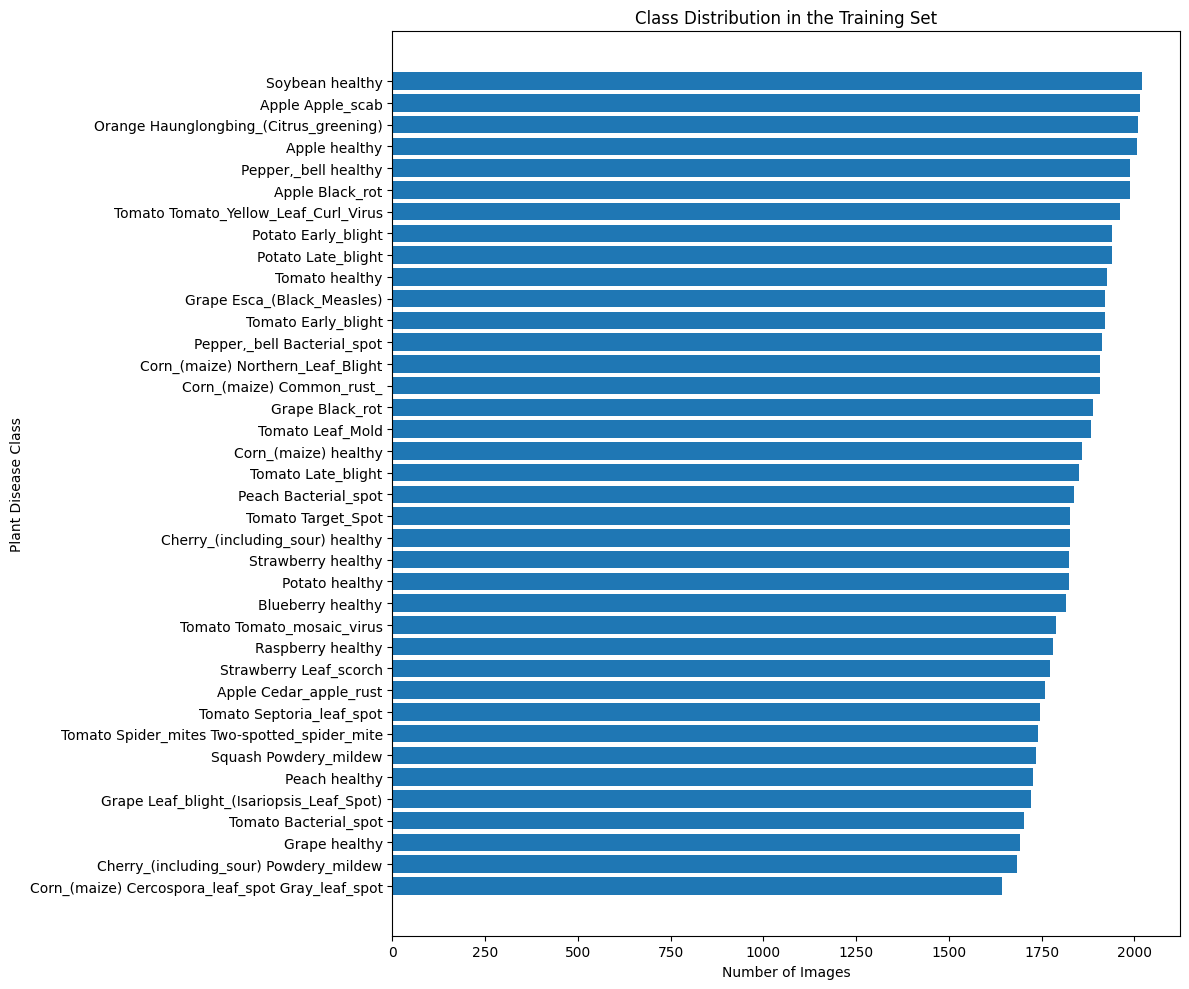

In [4]:
# Path to the training directory
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'

# Get class names and the number of images in each class
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name.replace("___", " ")] = len(os.listdir(class_path))

# Sort the classes by the number of images
sorted_counts = sorted(class_counts.items(), key=lambda item: item[1])
sorted_class_names = [item[0] for item in sorted_counts]
sorted_image_counts = [item[1] for item in sorted_counts]

# Plot the distribution
plt.figure(figsize=(12, 10))
plt.barh(sorted_class_names, sorted_image_counts)
plt.xlabel("Number of Images")
plt.ylabel("Plant Disease Class")
plt.title("Class Distribution in the Training Set")
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
INITIAL_EPOCHS = 5
FINE_TUNE_EPOCHS = 20
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ],
    name="data_augmentation",
)

base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

# Freeze the convolutional base to use its learned features
base_model.trainable = False

# Create the new model on top
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# --- 2. Compile the Model for Initial Training ---
# Use a standard learning rate for training the new top layer.
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("--- MODEL SUMMARY (BEFORE FINE-TUNING) ---")
model.summary()

# --- 3. Initial Training (Feature Extraction) ---
print("\n--- STARTING INITIAL TRAINING (FEATURE EXTRACTION) ---")
history = model.fit(train_dataset,
                    epochs=INITIAL_EPOCHS,
                    validation_data=validation_dataset)

# --- 4. Prepare for Fine-Tuning ---
# Unfreeze the base_model.
base_model.trainable = True

# Let's fine-tune from layer 100 onwards.
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# --- 5. Re-compile the Model for Fine-Tuning ---
# Re-compile with a much lower learning rate to make small adjustments.
model.compile(optimizer=Adam(learning_rate=0.0001), # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- MODEL SUMMARY (AFTER PREPARING FOR FINE-TUNING) ---")
model.summary() # Note the higher number of trainable parameters

# Stop training when validation accuracy has stopped improving for 3 epochs.
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
# Reduce the learning rate when validation accuracy plateaus.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.00001)

# --- 6. Continue Training (Fine-Tuning) ---
print("\n--- STARTING FINE-TUNING ---")
history_fine = model.fit(train_dataset,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=INITIAL_EPOCHS, # Start from where we left off
                         validation_data=validation_dataset,
                         callbacks=[early_stopping, reduce_lr])

print("\nAdvanced Training and fine-tuning finished!")

--- MODEL SUMMARY (BEFORE FINE-TUNING) ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)


--- STARTING INITIAL TRAINING (FEATURE EXTRACTION) ---
Epoch 1/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 175s 76ms/step - accuracy: 0.3224 - loss: 2.4995 - val_accuracy: 0.3520 - val_loss: 2.3219
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 142s 65ms/step - accuracy: 0.5144 - loss: 1.6567 - val_accuracy: 0.3829 - val_loss: 2.2223
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 142s 64ms/step - accuracy: 0.5309 - loss: 1.5832 - val_accuracy: 0.3846 - val_loss: 2.2696
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 142s 65ms/step - accuracy: 0.5414 - loss: 1.5512 - val_accuracy: 0.3716 - val_loss: 2.3569
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 142s 65ms/step - accuracy: 0.5502 - loss: 1.5258 - val_accuracy: 0.3879 - val_loss: 2.3072

--- MODEL SUMMARY (AFTER PREPARING FOR FINE-TUNING) ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)


--- STARTING FINE-TUNING ---
Epoch 6/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 241s 101ms/step - accuracy: 0.4979 - loss: 2.2539 - val_accuracy: 0.4993 - val_loss: 2.3813 - learning_rate: 1.0000e-04
Epoch 7/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 220s 100ms/step - accuracy: 0.7864 - loss: 0.6680 - val_accuracy: 0.6271 - val_loss: 1.5596 - learning_rate: 1.0000e-04
Epoch 8/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 220s 100ms/step - accuracy: 0.8507 - loss: 0.4678 - val_accuracy: 0.6123 - val_loss: 1.5362 - learning_rate: 1.0000e-04
Epoch 9/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 220s 100ms/step - accuracy: 0.8784 - loss: 0.3701 - val_accuracy: 0.7626 - val_loss: 0.8463 - learning_rate: 1.0000e-04
Epoch 10/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 220s 100ms/step - accuracy: 0.8977 - loss: 0.3119 - val_accuracy: 0.6694 - val_loss: 1.3808 - learning_rate: 1.0000e-04
Epoch 11/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 220s 100ms/step - accuracy: 0.9130 - loss: 0.2633 - val_accuracy: 0.7737 - val_loss: 0.7767 - learning_rate: 1.0000e

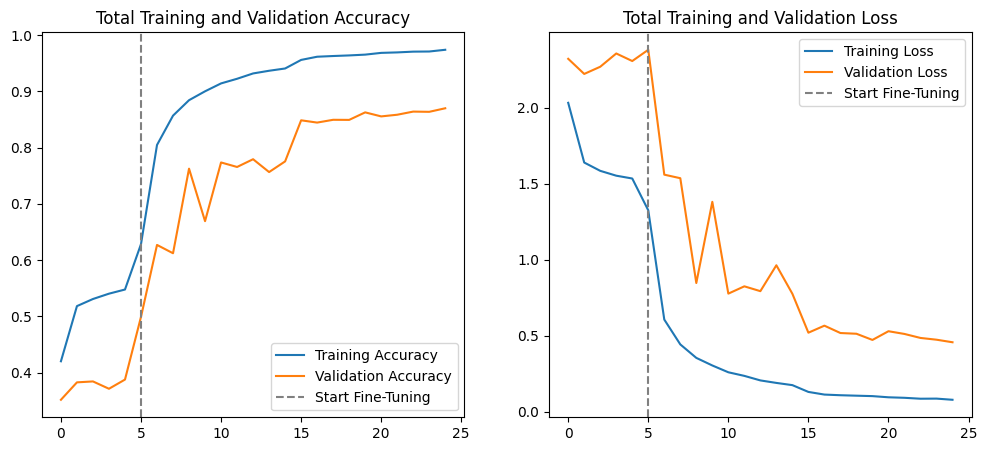

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# FIX: Calculate the epochs range directly from the length of our accuracy list
epochs_range = range(len(acc))

# Plot the combined results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# Use INITIAL_EPOCHS (defined in the training cell) to show where fine-tuning started
plt.axvline(INITIAL_EPOCHS, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Total Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# Use INITIAL_EPOCHS to show where fine-tuning started
plt.axvline(INITIAL_EPOCHS, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Total Training and Validation Loss')
plt.show()


Making predictions on a batch of validation images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

.............

************...


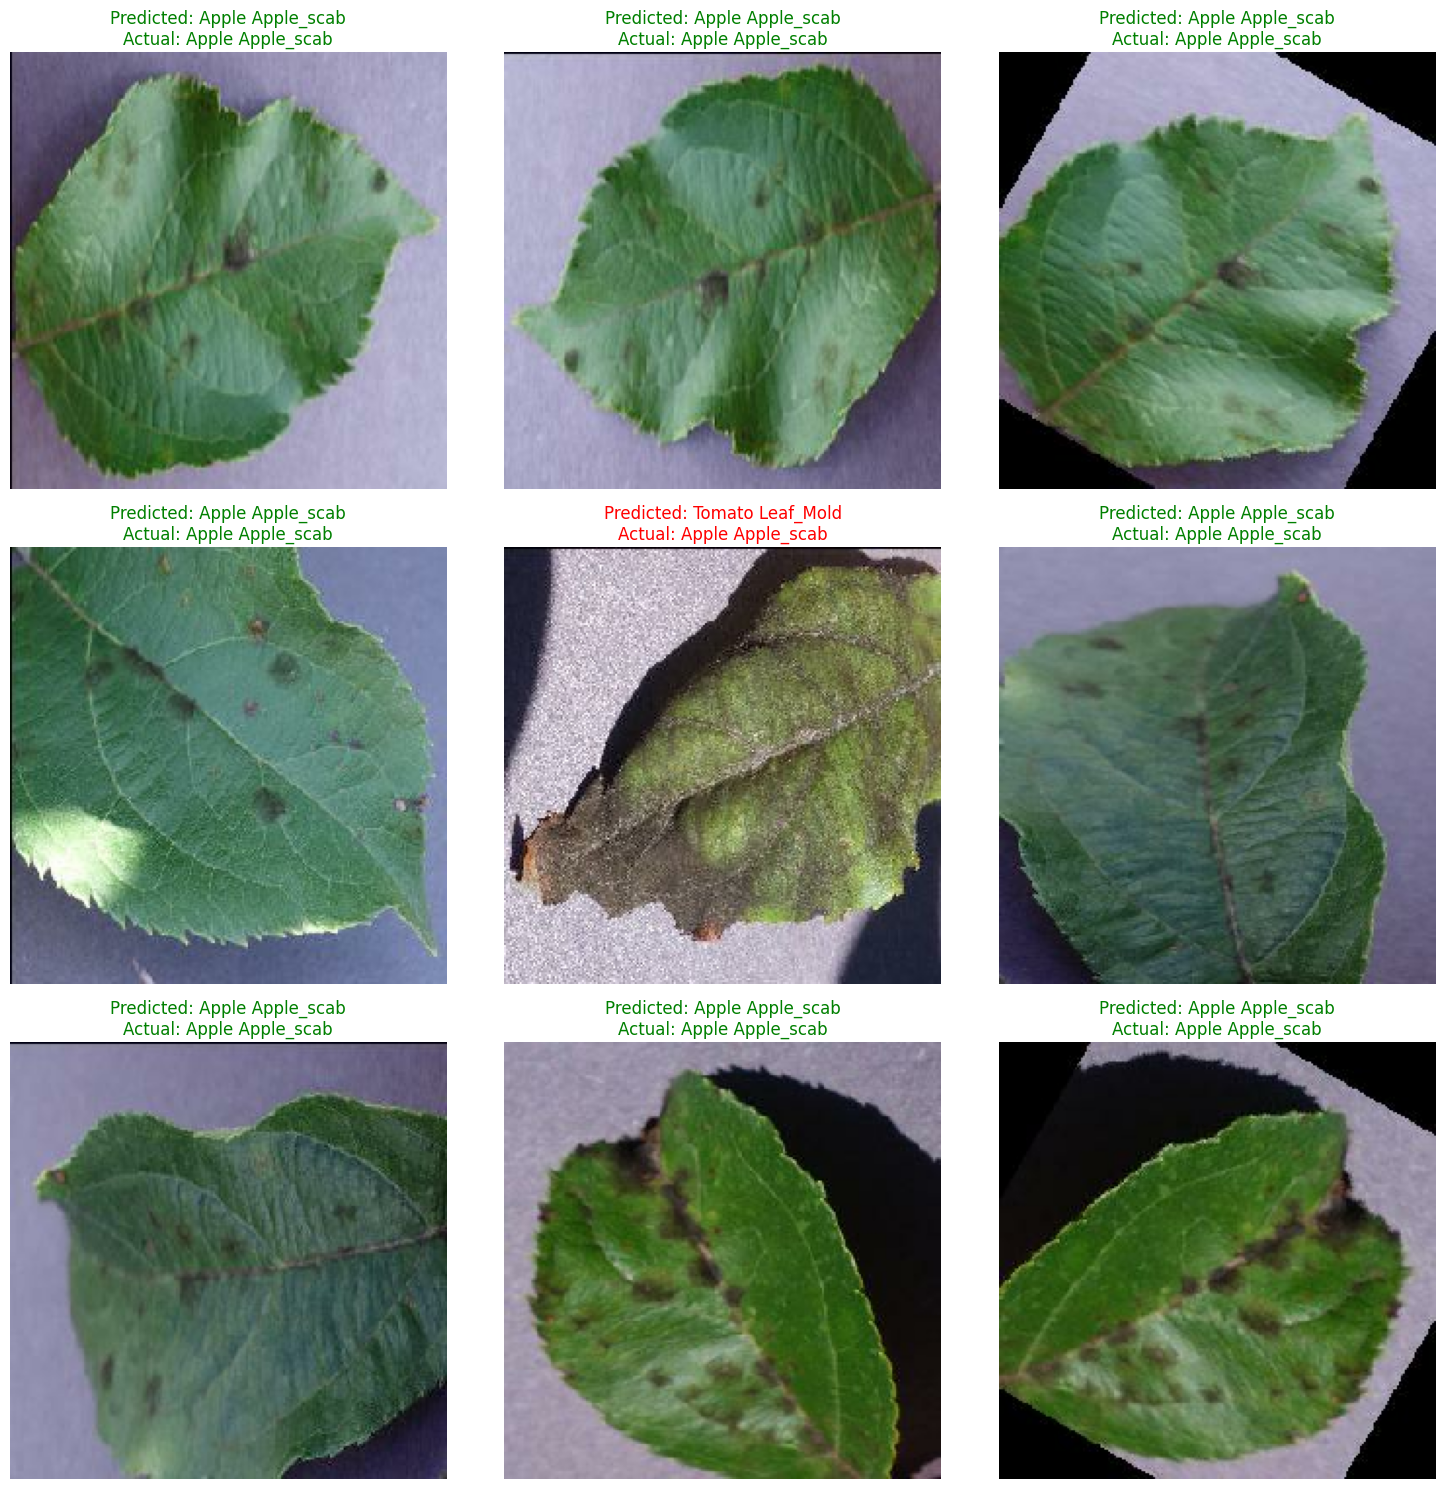

In [7]:
# --- 9. Make Predictions on New Images ---
# This part of your code was correct, as it uses the final 'model' object.
print("\nMaking predictions on a batch of validation images...")

for images, labels in validation_dataset.take(1):
    predictions = model.predict(images)
    print("\n.............")
    predicted_indices = np.argmax(predictions, axis=1)
    actual_indices = np.argmax(labels, axis=1)
    
    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class = class_names[predicted_indices[i]]
        actual_class = class_names[actual_indices[i]]
        
        title_color = "green" if predicted_class == actual_class else "red"
        
        plt.title(f"Predicted: {predicted_class.replace('___', ' ')}\nActual: {actual_class.replace('___', ' ')}", color=title_color)
        plt.axis("off")
    plt.tight_layout()
    print("\n************...")
    plt.show()

Gathering all predictions and labels from the validation set...
550/550 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step

--- CLASSIFICATION REPORT ---
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.85      0.88      0.87       504
                                 Apple___Black_rot       0.89      0.95      0.92       497
                          Apple___Cedar_apple_rust       0.99      0.87      0.93       440
                                   Apple___healthy       0.85      0.89      0.87       502
                               Blueberry___healthy       0.98      0.84      0.90       454
          Cherry_(including_sour)___Powdery_mildew       0.98      0.88      0.93       421
                 Cherry_(including_sour)___healthy       0.86      0.97      0.91       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.77      0.89      0.83       410
                       Corn_(maiz

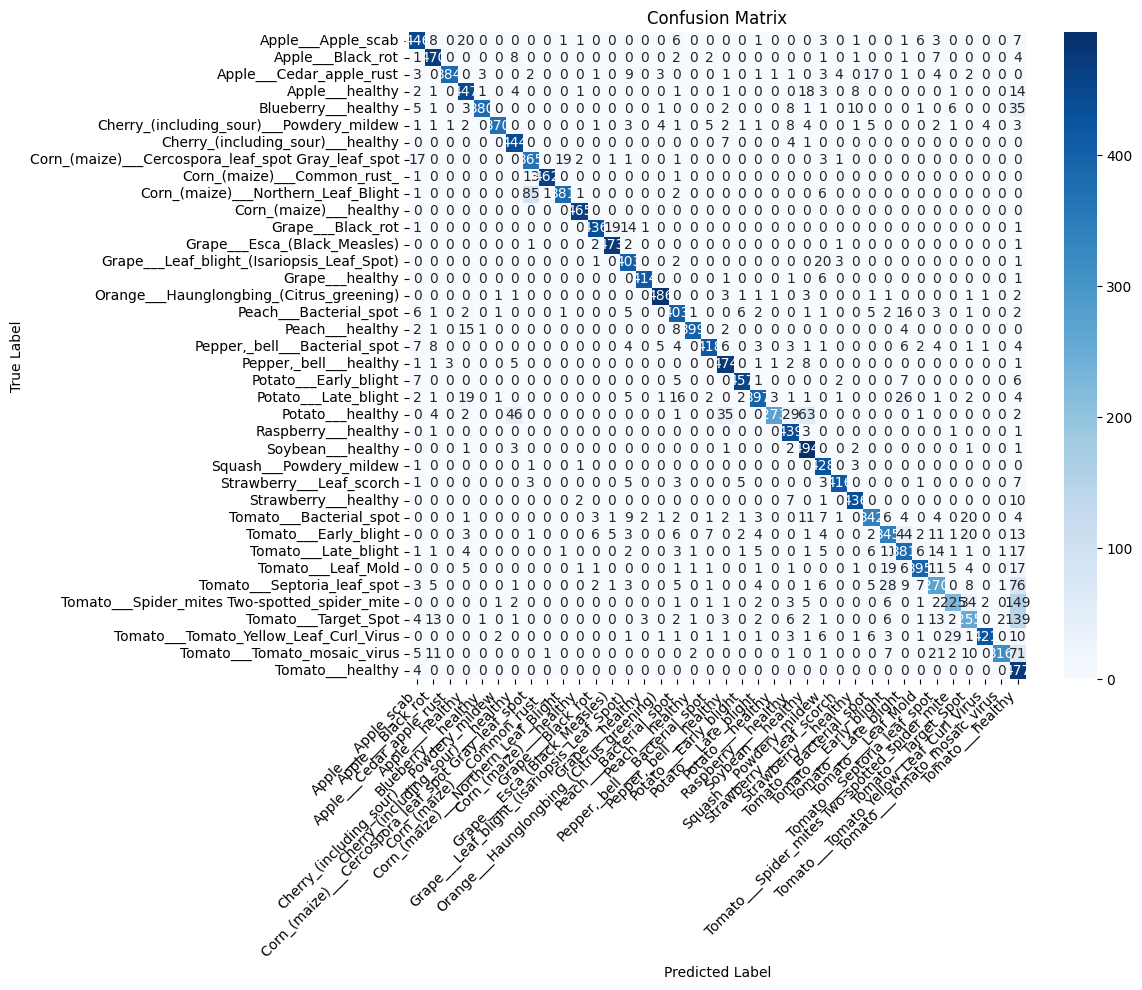

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Advanced Model Evaluation ---

# To create a report, we need to get all predictions and labels from the validation set.
print("Gathering all predictions and labels from the validation set...")

# Unbatch the validation dataset and convert it to a NumPy iterator
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
# Make predictions on the entire validation dataset
predictions = model.predict(validation_dataset)
# Convert predictions and true labels to class indices
y_pred = np.argmax(predictions, axis=1)
y_true_indices = np.argmax(y_true, axis=1)

# --- 1. Classification Report ---
print("\n--- CLASSIFICATION REPORT ---")
# This report shows precision, recall, and f1-score for every class.
print(classification_report(y_true_indices, y_pred, target_names=class_names))


# --- 2. Confusion Matrix ---
print("\n--- CONFUSION MATRIX ---")
# This matrix shows where the model is getting confused.
conf_matrix = confusion_matrix(y_true_indices, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
# Rotate labels for better readability if they overlap
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
# --- 10. Save the Model ---
print("Saving model...")

# Define the file path for the saved model
model_save_path = 'plant_disease_model_final.keras'

# Save the entire model to a single file.
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

# You can also save the class names for use in your app
import json
class_names_path = 'class_names_final.json'
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)

print(f"Class names saved to {class_names_path}")

Saving model...
Model saved to plant_disease_model_final.keras
Class names saved to class_names_final.json
